# Libraries import

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import transforms, utils, datasets
from torchvision.datasets import MNIST, FashionMNIST, USPS, SVHN
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.cluster import SpectralClustering, KMeans
from sklearn.preprocessing import normalize 
from sklearn.decomposition import PCA 
from sklearn.metrics import accuracy_score
import plotly.express as px
import os
import glob
from IPython.display import display, clear_output
import cv2

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Helper functions

## For displaying images

In [2]:
plt.rcParams["figure.figsize"] = (15, 14)

def subplot_show(images, titles = None, shape=None):
  for idx, img in enumerate(images):
    plt.subplot(*shape, idx+1)
    plt.subplots_adjust(top=0.55)
    plt.title(titles[idx])

    cmap = 'gray' if (len(img.shape) == 2 or img.shape[2] == 1) else None
    plt.imshow(img, cmap=cmap)
  plt.show()

## For flatten a list

In [3]:
flatten = lambda l: [item for sublist in l for item in sublist]

## For converting output tensors to images

In [4]:
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x

## Class rate scrore

Score = (count of majority samples in cluster) / (count of cluster samples)

In [5]:
def score(data: list) -> float:
  correct, overall = 0, 0
  for d in data:
    values = list(d.values())
    correct += values[0]
    overall += sum(values)
  return correct / overall

# Datasets downloading

In [6]:
transform = transforms.Compose(
    [transforms.ToTensor()])

mnist_train = MNIST('./data/', train=True, download=True, transform=transform)
mnist_test = MNIST('./data/', train=False, download=True, transform=transform)
fmnist_train = FashionMNIST('./data', train=True, download=True, transform=transform)
fmnist_test = FashionMNIST('./data', train=False, download=True, transform=transform)
usps_train = USPS('./data', train=True, download=True, transform=transform)
usps_test = USPS('./data', train=False, download=True, transform=transform)

clear_output()

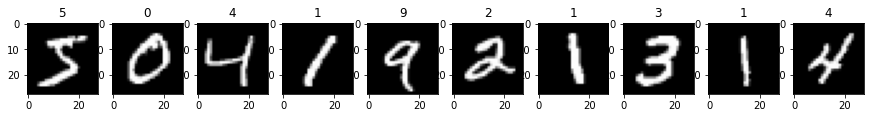

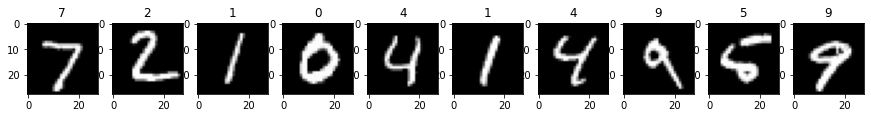

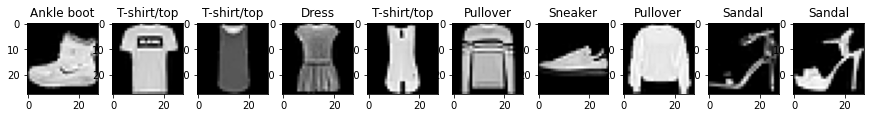

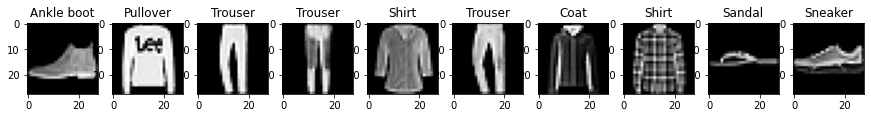

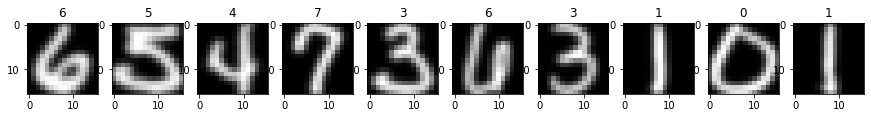

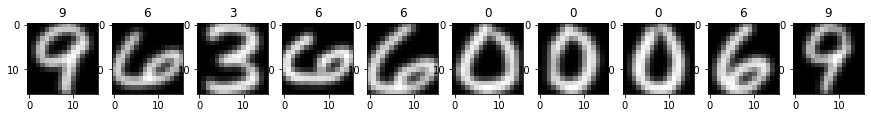

In [7]:
subplot_show(mnist_train.data[:10], mnist_train.targets.numpy()[:10], (1, 10))
subplot_show(mnist_test.data[:10], mnist_test.targets.numpy()[:10], (1, 10))
subplot_show(fmnist_train.data[:10], [fmnist_train.classes[lab] 
                                      for lab in fmnist_train.
                                      targets.numpy()[:10]], (1, 10))
subplot_show(fmnist_test.data[:10], [fmnist_test.classes[lab] 
                                     for lab in fmnist_test.
                                     targets.numpy()[:10]], (1, 10))
subplot_show(usps_train.data[:10], usps_train.targets[:10], (1, 10))
subplot_show(usps_test.data[:10], usps_test.targets[:10], (1, 10))

# Dataloaders

In [8]:
mnist_train_loader = torch.utils.data.DataLoader(
    mnist_train, batch_size=128, shuffle=False, num_workers=4, pin_memory=True
)

mnist_test_loader = torch.utils.data.DataLoader(
    mnist_test, batch_size=32, shuffle=False, num_workers=4
)

fmnist_train_loader = torch.utils.data.DataLoader(
    fmnist_train, batch_size=128, shuffle=False, num_workers=4, pin_memory=True
)

fmnist_test_loader = torch.utils.data.DataLoader(
    fmnist_test, batch_size=128, shuffle=False, num_workers=4
)

usps_train_loader = torch.utils.data.DataLoader(
    usps_train, batch_size=128, shuffle=False, num_workers=4, pin_memory=True
)

usps_test_loader = torch.utils.data.DataLoader(
    usps_test, batch_size=128, shuffle=False, num_workers=4
)

# Device for model training

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Simple multilayer Autoencoder model

In [10]:
class AE(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.encoder_hidden_layer = nn.Linear(
            in_features=kwargs["input_shape"], out_features=128
        )
        self.encoder_output_layer = nn.Linear(
            in_features=128, out_features=128
        )
        self.decoder_hidden_layer = nn.Linear(
            in_features=128, out_features=128
        )
        self.decoder_output_layer = nn.Linear(
            in_features=128, out_features=kwargs["input_shape"]
        )

    def forward(self, features):
        activation = self.encoder_hidden_layer(features)
        activation = torch.relu(activation)
        code = self.encoder_output_layer(activation)
        code = torch.relu(code)
        activation = self.decoder_hidden_layer(code)
        activation = torch.relu(activation)
        activation = self.decoder_output_layer(activation)
        reconstructed = torch.relu(activation)
        return reconstructed

In [11]:
# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
simple_ae_model = AE(input_shape=784).to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
simple_ae_optimizer = optim.Adam(simple_ae_model.parameters(), lr=1e-3)

# mean-squared error loss
simple_ae_criterion = nn.MSELoss()

# Convolutional Autoencoder model

In [12]:
class AE_CONV(nn.Module):
    def __init__(self):
        super(AE_CONV, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=3, padding=1),  # b, 16, 10, 10
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            nn.Conv2d(16, 8, 3, stride=2, padding=1),  # b, 8, 3, 3
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1)  # b, 8, 2, 2
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 3, stride=2),  # b, 16, 5, 5
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),  # b, 8, 15, 15
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),  # b, 1, 28, 28
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [13]:
# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
conv_ae_model = AE_CONV().to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
conv_ae_optimizer = optim.Adam(conv_ae_model.parameters(), lr=1e-3,
                             weight_decay=1e-5)

# mean-squared error loss
conv_ae_criterion = nn.MSELoss()

# Varitational Autoencoder model

In [14]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return F.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar

In [15]:
# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
var_ae_model = VAE().to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
var_ae_optimizer = optim.Adam(var_ae_model.parameters(), lr=1e-3,
                             weight_decay=1e-5)

# mean-squared error loss
var_ae_criterion = nn.MSELoss(size_average=False)

def var_ae_loss(recon_x, x, mu, logvar):
    """
    recon_x: generating images
    x: origin images
    mu: latent mean
    logvar: latent log variance
    """
    BCE = var_ae_criterion(recon_x, x)  # mse loss
    # loss = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)
    # KL divergence
    return BCE + KLD

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning:

size_average and reduce args will be deprecated, please use reduction='sum' instead.



# Training a simple multilayer autoencoder on MNIST train 

In [16]:
epochs = 20
mnist_train_ae = []

for epoch in range(1, epochs+1):
    loss = 0
    for batch_feats, _ in mnist_train_loader:
        # reshape mini-batch data to [N, 784] matrix
        # load it to the active device
        batch_feats = batch_feats.view(batch_feats.size(0), -1).to(device)
        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        simple_ae_optimizer.zero_grad()
        
        # compute reconstructions
        output = simple_ae_model(batch_feats)
        if epoch == epochs:
          mnist_train_ae.append(output)
        
        # compute training reconstruction loss
        train_loss = simple_ae_criterion(output, batch_feats)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        simple_ae_optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
    
    # compute the epoch training loss
    loss = loss / len(mnist_train_loader)
    
    # display the epoch training loss
    print(f'epoch: {epoch}/{epochs}, loss = {loss:.6f}')

epoch: 1/20, loss = 0.034297
epoch: 2/20, loss = 0.019550
epoch: 3/20, loss = 0.017342
epoch: 4/20, loss = 0.016259
epoch: 5/20, loss = 0.015586
epoch: 6/20, loss = 0.015111
epoch: 7/20, loss = 0.014743
epoch: 8/20, loss = 0.014452
epoch: 9/20, loss = 0.014221
epoch: 10/20, loss = 0.014041
epoch: 11/20, loss = 0.013892
epoch: 12/20, loss = 0.013758
epoch: 13/20, loss = 0.013627
epoch: 14/20, loss = 0.013502
epoch: 15/20, loss = 0.013391
epoch: 16/20, loss = 0.013297
epoch: 17/20, loss = 0.013216
epoch: 18/20, loss = 0.013147
epoch: 19/20, loss = 0.013086
epoch: 20/20, loss = 0.013030


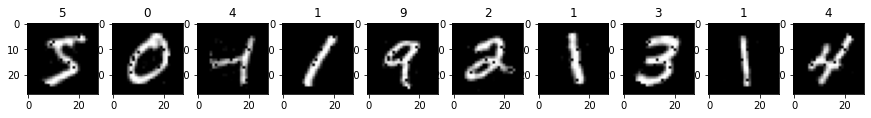

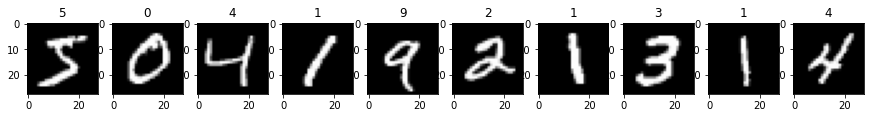

In [17]:
mnist_train_ae = [to_img(out.cpu().data).numpy() for out in mnist_train_ae]
mnist_train_ae = [out.transpose(1,2,0)[:,:,0] for out in flatten(mnist_train_ae)]

subplot_show(mnist_train_ae[:10], mnist_train.targets.numpy()[:10], (1,10))
subplot_show(mnist_train.data[:10], mnist_train.targets.numpy()[:10], (1, 10))

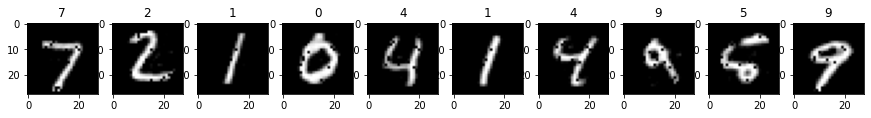

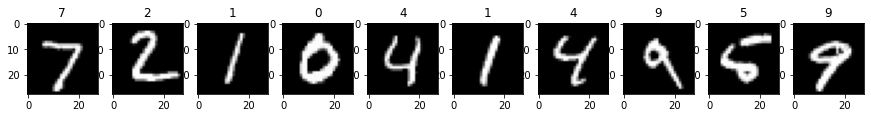

In [18]:
mnist_test_ae = []

for batch_feats, _ in mnist_test_loader:
  batch_feats = batch_feats.view(batch_feats.size(0), -1).to(device)
  mnist_test_ae.append(simple_ae_model(batch_feats))

mnist_test_ae = [to_img(out.cpu().data).numpy() for out in mnist_test_ae]
mnist_test_ae = [out.transpose(1,2,0)[:,:,0] for out in flatten(mnist_test_ae)]

subplot_show(mnist_test_ae[:10], mnist_test.targets.numpy()[:10], (1,10))
subplot_show(mnist_test.data[:10], mnist_test.targets.numpy()[:10], (1, 10))

# Convolutional autoencoder on USPS

In [19]:
epochs = 30
usps_train_ae = []

for epoch in range(1, epochs+1):
    loss = 0
    for batch_feats, _ in usps_train_loader:
        # reshape mini-batch data to [N, 784] matrix
        # load it to the active device
        batch_feats = Variable(batch_feats).to(device)

        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        conv_ae_optimizer.zero_grad()
        
        # compute reconstructions
        output = conv_ae_model(batch_feats)
        if epoch == epochs:
          usps_train_ae.append(output)
        
        # compute training reconstruction loss
        train_loss = conv_ae_criterion(output, batch_feats)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        conv_ae_optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
    
    # compute the epoch training loss
    loss = loss / len(usps_train_loader)
    
    # display the epoch training loss
    print(f'epoch: {epoch}/{epochs}, loss = {loss:.6f}')

epoch: 1/30, loss = 0.327389
epoch: 2/30, loss = 0.130252
epoch: 3/30, loss = 0.069036
epoch: 4/30, loss = 0.059514
epoch: 5/30, loss = 0.055829
epoch: 6/30, loss = 0.052916
epoch: 7/30, loss = 0.047570
epoch: 8/30, loss = 0.043113
epoch: 9/30, loss = 0.040618
epoch: 10/30, loss = 0.038903
epoch: 11/30, loss = 0.037454
epoch: 12/30, loss = 0.036063
epoch: 13/30, loss = 0.034760
epoch: 14/30, loss = 0.033657
epoch: 15/30, loss = 0.032739
epoch: 16/30, loss = 0.031948
epoch: 17/30, loss = 0.031204
epoch: 18/30, loss = 0.030466
epoch: 19/30, loss = 0.029700
epoch: 20/30, loss = 0.028816
epoch: 21/30, loss = 0.027988
epoch: 22/30, loss = 0.027169
epoch: 23/30, loss = 0.026383
epoch: 24/30, loss = 0.025701
epoch: 25/30, loss = 0.025113
epoch: 26/30, loss = 0.024592
epoch: 27/30, loss = 0.024130
epoch: 28/30, loss = 0.023712
epoch: 29/30, loss = 0.023327
epoch: 30/30, loss = 0.022970


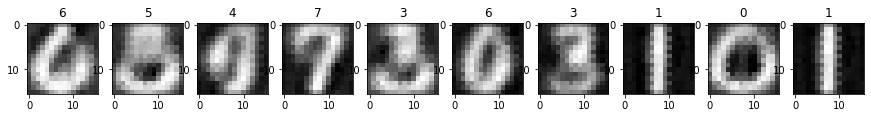

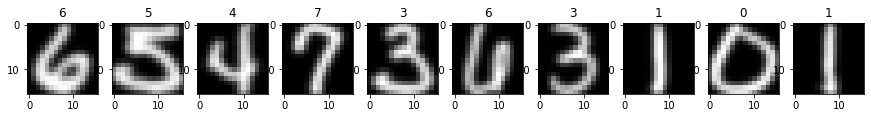

In [20]:
usps_train_ae = [(out.cpu().data).numpy() for out in usps_train_ae]
usps_train_ae = [out.transpose(1,2,0)[:,:,0] for out in flatten(usps_train_ae)]

subplot_show(usps_train_ae[:10], usps_train.targets[:10], (1,10))
subplot_show(usps_train.data[:10], usps_train.targets[:10], (1, 10))

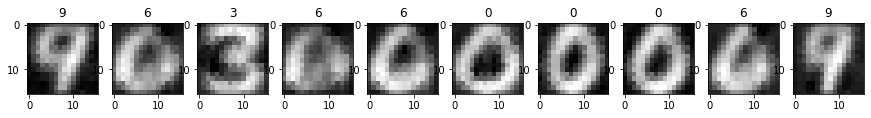

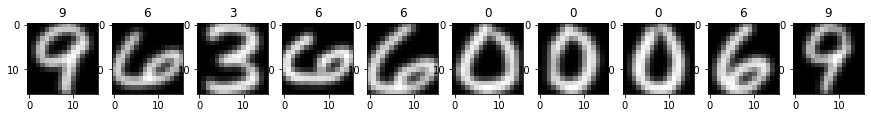

In [21]:
usps_test_ae = []

for batch_feats, _ in usps_test_loader:
  batch_feats = Variable(batch_feats).to(device) 
  usps_test_ae.append(conv_ae_model(batch_feats))

usps_test_ae = [(out.cpu().data).numpy() for out in usps_test_ae]
usps_test_ae = [out.transpose(1,2,0)[:,:,0] for out in flatten(usps_test_ae)]

subplot_show(usps_test_ae[:10], usps_test.targets[:10], (1,10))
subplot_show(usps_test.data[:10], usps_test.targets[:10], (1, 10))

# Variational autoencoder on Fashion Mnist

In [22]:
epochs = 20

for epoch in range(1, epochs+1):
    var_ae_model.train()
    train_loss = 0
    for batch_idx, data in enumerate(fmnist_train_loader):
        img, _ = data
        img = img.view(img.size(0), -1)
        img = Variable(img)
        if torch.cuda.is_available():
            img = img.cuda()
        var_ae_optimizer.zero_grad()
        recon_batch, mu, logvar = var_ae_model(img)
        loss = var_ae_loss(recon_batch, img, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        var_ae_optimizer.step()

    print('====> Epoch: {} Average loss: {:.4f}'.format(
        epoch, train_loss / len(fmnist_train_loader.dataset)))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1625: UserWarning:

nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.



====> Epoch: 1 Average loss: 39.7171
====> Epoch: 2 Average loss: 29.5425
====> Epoch: 3 Average loss: 27.6225
====> Epoch: 4 Average loss: 26.6950
====> Epoch: 5 Average loss: 26.1850
====> Epoch: 6 Average loss: 25.8375
====> Epoch: 7 Average loss: 25.5371
====> Epoch: 8 Average loss: 25.3131
====> Epoch: 9 Average loss: 25.1177
====> Epoch: 10 Average loss: 24.9664
====> Epoch: 11 Average loss: 24.8224
====> Epoch: 12 Average loss: 24.7159
====> Epoch: 13 Average loss: 24.6793
====> Epoch: 14 Average loss: 24.5532
====> Epoch: 15 Average loss: 24.4668
====> Epoch: 16 Average loss: 24.4223
====> Epoch: 17 Average loss: 24.3594
====> Epoch: 18 Average loss: 24.2991
====> Epoch: 19 Average loss: 24.2420
====> Epoch: 20 Average loss: 24.2240


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1625: UserWarning:

nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.



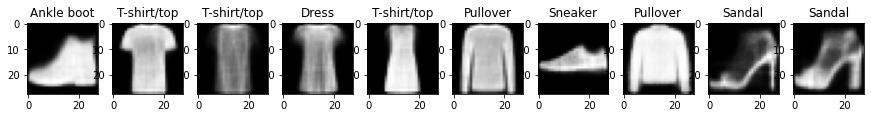

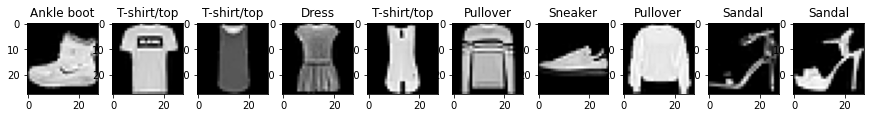

In [23]:
fmnist_train_ae = []

for batch_feats, _ in fmnist_train_loader:
  batch_feats = batch_feats.view(batch_feats.size(0), -1).to(device)
  fmnist_train_ae.append(var_ae_model(batch_feats))

fmnist_train_ae = [to_img(out[0].cpu().data).numpy() for out in fmnist_train_ae]
fmnist_train_ae = [out.transpose(1,2,0)[:,:,0] for out in flatten(fmnist_train_ae)]

subplot_show(fmnist_train_ae[:10], [fmnist_train.classes[lab] 
                                     for lab in fmnist_train.
                                     targets.numpy()[:10]], (1, 10))
subplot_show(fmnist_train.data[:10], [fmnist_train.classes[lab] 
                                     for lab in fmnist_train.
                                     targets.numpy()[:10]], (1, 10))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1625: UserWarning:

nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.



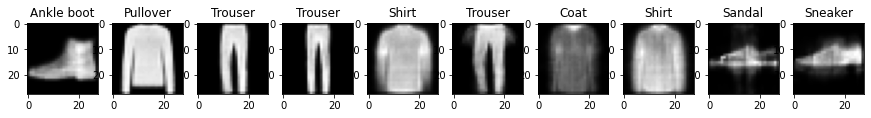

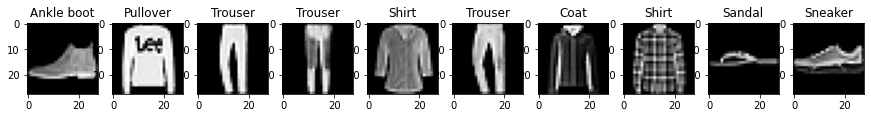

In [24]:
fmnist_test_ae = []

for batch_feats, _ in fmnist_test_loader:
  batch_feats = batch_feats.view(batch_feats.size(0), -1).to(device)
  fmnist_test_ae.append(var_ae_model(batch_feats))

fmnist_test_ae = [to_img(out[0].cpu().data).numpy() for out in fmnist_test_ae]
fmnist_test_ae = [out.transpose(1,2,0)[:,:,0] for out in flatten(fmnist_test_ae)]

subplot_show(fmnist_test_ae[:10], [fmnist_test.classes[lab] 
                                     for lab in fmnist_test.
                                     targets.numpy()[:10]], (1, 10))
subplot_show(fmnist_test.data[:10], [fmnist_test.classes[lab] 
                                     for lab in fmnist_test.
                                     targets.numpy()[:10]], (1, 10))

# Spectral clustering part

<font size='4'>It looks like "predicted labels" are internal for clusterifier, while "true labels" are given with dataset</font>


## MNIST

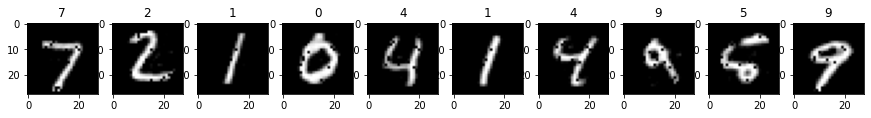

In [25]:
x = np.asarray([mn.flatten() for mn in mnist_test_ae])
y_true = mnist_test.targets.numpy()

subplot_show(mnist_test_ae[:10], y_true[:10], (1,10))


In [26]:
comps = 10

# Building the clustering model 
spectral_model = SpectralClustering(n_clusters=comps, affinity ='rbf', n_jobs=4)

# Try KMeans as clusterizator
kmeans = KMeans(n_clusters=comps)

In [27]:
# Normalizing the Data 
X_normalized = normalize(x) 
  
# Converting the numpy array into a pandas DataFrame 
X_normalized = pd.DataFrame(X_normalized) 

# Reducing the dimensions of the data

pca = PCA(n_components = comps) 
X_principal = pca.fit_transform(X_normalized) 
X_principal = pd.DataFrame(X_principal) 
X_principal.columns = ['P{}'.format(i) for i in range(comps)]

# Training the model and Storing the predicted cluster labels 
X_principal['pred'] = spectral_model.fit_predict(X_principal)
X_principal['true'] = y_true

# Show the clusterization accuracy as majority to cluster.sum()
data = []
for i in X_principal['true'].unique():
  buf = X_principal[X_principal['true']==i]['pred'].value_counts()[:5].to_dict()
  keys = list(buf.keys())
  data.append(buf)
  print(f'True label "{i}" == predicted label "{keys[0]}"', 'with class rate {:.6f}%'.format(buf[keys[0]] / sum(buf.values())*100))

print("Majority score:", score(data))
fig_1 = px.scatter_3d(X_principal, x='P0', y='P1', z='P2', color=X_principal['pred'], size_max=10, color_continuous_scale='Plasma', 
                      title='Predicted clusters by SpectralClustering, reduced to 3D')
fig_1.show()

True label "7" == predicted label "7" with class rate 70.558882%
True label "2" == predicted label "9" with class rate 74.557522%
True label "1" == predicted label "4" with class rate 56.035242%
True label "0" == predicted label "1" with class rate 58.659794%
True label "4" == predicted label "6" with class rate 62.159329%
True label "9" == predicted label "6" with class rate 46.499478%
True label "5" == predicted label "8" with class rate 33.130329%
True label "6" == predicted label "5" with class rate 75.053996%
True label "3" == predicted label "0" with class rate 77.628866%
True label "8" == predicted label "2" with class rate 65.714286%
Majority score: 0.6222641114252802


In [28]:
X_principal['pred'] = kmeans.fit_predict(X_principal)

# Show the clusterization accuracy as majority to cluster.sum()
data = []
for i in X_principal['true'].unique():
  buf = X_principal[X_principal['true']==i]['pred'].value_counts()[:5].to_dict()
  keys = list(buf.keys())
  data.append(buf)
  print(f'True label "{i}" == predicted label "{keys[0]}"', 'with class rate {:.6f}%'.format(buf[keys[0]] / sum(buf.values())*100))

print("Majority score:", score(data))
fig_1 = px.scatter_3d(X_principal, x='P0', y='P1', z='P2', color=X_principal['pred'], size_max=10, color_continuous_scale='Plasma', 
                      title='Predicted clusters by KMeans, reduced to 3D')
fig_1.show()

True label "7" == predicted label "6" with class rate 71.108949%
True label "2" == predicted label "5" with class rate 70.542636%
True label "1" == predicted label "4" with class rate 99.647577%
True label "0" == predicted label "7" with class rate 61.122449%
True label "4" == predicted label "0" with class rate 68.126273%
True label "9" == predicted label "2" with class rate 60.852329%
True label "5" == predicted label "1" with class rate 35.426009%
True label "6" == predicted label "8" with class rate 80.167015%
True label "3" == predicted label "9" with class rate 74.653465%
True label "8" == predicted label "3" with class rate 86.960986%
Majority score: 0.7157


## Fashion-MNIST

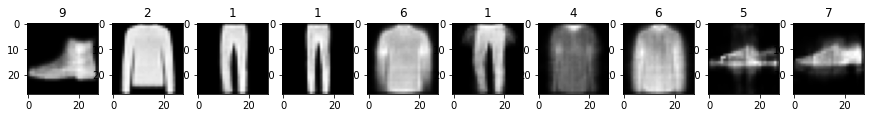

In [29]:
x = np.asarray([mn.flatten() for mn in fmnist_test_ae])
y_true = fmnist_test.targets.numpy()

subplot_show(fmnist_test_ae[:10], y_true[:10], (1,10))

In [30]:
# Normalizing the Data 
X_normalized = normalize(x) 
  
# Converting the numpy array into a pandas DataFrame 
X_normalized = pd.DataFrame(X_normalized) 

# Reducing the dimensions of the data
comps = 10
pca = PCA(n_components = comps) 
X_principal = pca.fit_transform(X_normalized) 
X_principal = pd.DataFrame(X_principal) 
X_principal.columns = ['P{}'.format(i) for i in range(comps)]

# Training the model and Storing the predicted cluster labels 
X_principal['pred'] = spectral_model.fit_predict(X_principal)
X_principal['true'] = y_true

# Show the clusterization accuracy as majority to cluster.sum()
data = []
for i in X_principal['true'].unique():
  buf = X_principal[X_principal['true']==i]['pred'].value_counts()[:5].to_dict()
  keys = list(buf.keys())
  data.append(buf)
  print(f'True label "{i}" == predicted label "{keys[0]}"', 'with class rate {:.6f}%'.format(buf[keys[0]] / sum(buf.values())*100))

print("Majority score:", score(data))
fig_1 = px.scatter_3d(X_principal, x='P0', y='P1', z='P2', color=X_principal['pred'], size_max=10, color_continuous_scale='Plasma', 
                      title='Predicted clusters by SpectralClustering, reduced to 3D')
fig_1.show()

True label "9" == predicted label "5" with class rate 48.144433%
True label "2" == predicted label "0" with class rate 48.645938%
True label "1" == predicted label "3" with class rate 85.470942%
True label "6" == predicted label "2" with class rate 32.926829%
True label "4" == predicted label "1" with class rate 51.810865%
True label "5" == predicted label "2" with class rate 50.151057%
True label "7" == predicted label "4" with class rate 70.570571%
True label "3" == predicted label "3" with class rate 48.893360%
True label "8" == predicted label "7" with class rate 43.890020%
True label "0" == predicted label "6" with class rate 69.074262%
Majority score: 0.5499445620401169


In [31]:
X_principal['pred'] = kmeans.fit_predict(X_principal)
X_principal['true'] = y_true

# Show the clusterization accuracy as majority to cluster.sum()
data = []
for i in X_principal['true'].unique():
  buf = X_principal[X_principal['true']==i]['pred'].value_counts()[:5].to_dict()
  keys = list(buf.keys())
  data.append(buf)
  print(f'True label "{i}" == predicted label "{keys[0]}"', 'with class rate {:.6f}%'.format(buf[keys[0]] / sum(buf.values())*100))

print("Majority score:", score(data))
fig_1 = px.scatter_3d(X_principal, x='P0', y='P1', z='P2', color=X_principal['pred'], size_max=10, color_continuous_scale='Plasma', 
                      title='Predicted clusters by KMeans, reduced to 3D')
fig_1.show()

True label "9" == predicted label "6" with class rate 52.100000%
True label "2" == predicted label "9" with class rate 73.600000%
True label "1" == predicted label "7" with class rate 93.200000%
True label "6" == predicted label "5" with class rate 77.300000%
True label "4" == predicted label "0" with class rate 86.800000%
True label "5" == predicted label "5" with class rate 49.900000%
True label "7" == predicted label "3" with class rate 91.800000%
True label "3" == predicted label "4" with class rate 65.400000%
True label "8" == predicted label "1" with class rate 83.500000%
True label "0" == predicted label "2" with class rate 69.500000%
Majority score: 0.7431


## USPS

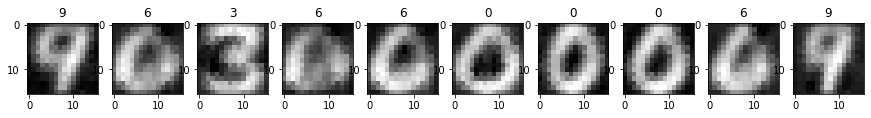

In [32]:
x = np.asarray([mn.flatten() for mn in usps_test_ae])
y_true = usps_test.targets

subplot_show(usps_test_ae[:10], y_true[:10], (1,10))

In [33]:
# Normalizing the Data 
X_normalized = normalize(x) 
  
# Converting the numpy array into a pandas DataFrame 
X_normalized = pd.DataFrame(X_normalized) 

# Reducing the dimensions of the data
comps = 10
pca = PCA(n_components = comps) 
X_principal = pca.fit_transform(X_normalized) 
X_principal = pd.DataFrame(X_principal) 
X_principal.columns = ['P{}'.format(i) for i in range(comps)]

# Training the model and Storing the predicted cluster labels 
X_principal['pred'] = spectral_model.fit_predict(X_principal)
X_principal['true'] = y_true

# Show the clusterization accuracy as majority to cluster.sum()
data = []
for i in X_principal['true'].unique():
  buf = X_principal[X_principal['true']==i]['pred'].value_counts()[:5].to_dict()
  keys = list(buf.keys())
  data.append(buf)
  print(f'True label "{i}" == predicted label "{keys[0]}"', 'with class rate {:.6f}%'.format(buf[keys[0]] / sum(buf.values())*100))

print("Majority score:", score(data))
fig_1 = px.scatter_3d(X_principal, x='P0', y='P1', z='P2', color=X_principal['pred'], size_max=10, color_continuous_scale='Plasma', 
                      title='Predicted clusters by SpectralClustering, reduced to 3D')
fig_1.show()

True label "9" == predicted label "6" with class rate 80.924855%
True label "6" == predicted label "7" with class rate 67.058824%
True label "3" == predicted label "0" with class rate 79.268293%
True label "0" == predicted label "3" with class rate 55.240793%
True label "2" == predicted label "8" with class rate 61.621622%
True label "4" == predicted label "6" with class rate 47.395833%
True label "1" == predicted label "1" with class rate 95.833333%
True label "8" == predicted label "4" with class rate 49.390244%
True label "7" == predicted label "5" with class rate 69.178082%
True label "5" == predicted label "0" with class rate 42.307692%
Majority score: 0.6532791052364006


In [34]:
X_principal['pred'] = kmeans.fit_predict(X_principal)
X_principal['true'] = y_true

# Show the clusterization accuracy as majority to cluster.sum()
data = []
for i in X_principal['true'].unique():
  buf = X_principal[X_principal['true']==i]['pred'].value_counts()[:5].to_dict()
  keys = list(buf.keys())
  data.append(buf)
  print(f'True label "{i}" == predicted label "{keys[0]}"', 'with class rate {:.6f}%'.format(buf[keys[0]] / sum(buf.values())*100))

print("Majority score:", score(data))
fig_1 = px.scatter_3d(X_principal, x='P0', y='P1', z='P2', color=X_principal['pred'], size_max=10, color_continuous_scale='Plasma', 
                      title='Predicted clusters by KMeans, reduced to 3D')
fig_1.show()

True label "9" == predicted label "6" with class rate 93.220339%
True label "6" == predicted label "0" with class rate 71.764706%
True label "3" == predicted label "4" with class rate 79.518072%
True label "0" == predicted label "7" with class rate 96.100279%
True label "2" == predicted label "9" with class rate 68.181818%
True label "4" == predicted label "5" with class rate 52.000000%
True label "1" == predicted label "1" with class rate 96.969697%
True label "8" == predicted label "2" with class rate 50.000000%
True label "7" == predicted label "2" with class rate 72.108844%
True label "5" == predicted label "8" with class rate 53.750000%
Majority score: 0.7643248629795715
